In [40]:
import pandas as pd
import matplotlib.pyplot as plt

ind_point = 10
file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]

# Read your dataframe (for example from a CSV file)
def read_and_plot(filename):
    df = pd.read_csv(f"set_transformer/resuls_SetTransformer/{filename}.csv",sep="\t")  # Replace with your file path
    plt.scatter(df['y_actual'], df['prediction'], marker='o', alpha = 0.3, c = "tab:blue")#, linestyle='-', color='b')


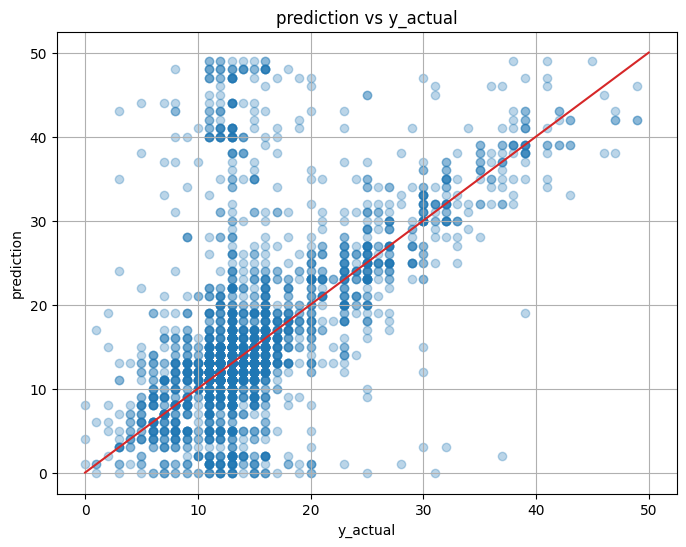

In [41]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.plot([0,50],[0,50], c = "tab:red")
for file in file_names_cv:
    read_and_plot(file)

plt.title('prediction vs y_actual')
plt.xlabel('y_actual')
plt.ylabel('prediction')


plt.show()